## Imports

In [1]:
from __future__ import division
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
from math import pi 
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal
import numpy as np
import matplotlib.pyplot as plt

# Introduction to Normalizing Flows

$\newcommand{bb}[1]{\mathbb{#1}}
\newcommand{bs}[1]{\boldsymbol{#1}}
\newcommand{mbf}[1]{\boldsymbol{\mathbf{#1}}}
\newcommand{mrm}[1]{\mathrm{#1}}
\newcommand{mcal}[1]{\mathcal{#1}}
\newcommand{\eps}{\epsilon}
\newcommand{\veps}{\varepsilon}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\indep}{{\perp\!\!\!\!\perp}}
\newcommand{\bigo}{\mathcal{O}}
\newcommand{\del}[2]{\frac{\partial#1}{\partial#2}}
\newcommand{\ddel}[3]{\frac{\partial^{^{#3}}\! #1}{\partial#2^{^{#3}}}}
\newcommand{\diff}[2]{\frac{d #1}{d #2}}
\newcommand{\ddiff}[3]{\frac{d^{^{#3}}\! #1}{ d #2^{^{#3}}}}
\newcommand{\Diff}[2]{\frac{ \mathrm{d}#1}{\mathrm{d}#2}}
\newcommand{\DDiff}[3]{\frac{\mathrm{d}^{^{#3}}\! #1}{ \mathrm{d} #2^{^{#3}}}}
\newcommand{\dx}{\mathop{}\!d}
\newcommand{\ddx}[1]{\mathop{}\!d^#1}
\newcommand{\Dx}{\mathop{}\!\mathrm{d}}
\newcommand{\DDx}[1]{\mathop{}\!\mathrm{d^#1}}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\newcommand{\tr}{\mathrm{Tr}}
\newcommand{\cov}{\mathrm{Cov}}
$



## Definition and basics 
Normalizing flows provide a general way of constructing flexible probability distributions over continuous random variables.

The main idea is to express $ \mathbf{x} \in \mathbb{R}^D $ as a transformation $T$ of a real vector $\mathbf{u}$ sampled from $p_\mathrm{u}(\mathbf{u})$, where $T$ must be *invertible* and both $T$ and $T^{-1}$ must be *differentiable*. Since $T$ is invertible, necessarily $\mathbf{u} \in \mathbb{R}^D$.

Under these conditions, the density of $\mathbf{x}$ is well-defined and can be written as $$p_\mathrm{x}(\mathbf{x}) = p_\mathrm{u}(\mathbf{u}) |\det J_T(\mathbf{u})|^{-1} = p_\mathrm{u}(T^{-1}(\mathbf{x})) |\det J_{T^{-1}}(\mathbf{x})| $$

In practice, $T$ ot $T^{-1}$ is implemented by a neural network and $p_\mathrm{u}(\mathbf{u})$ is taken to be a simple density such as a multivariate normal.

Intuitively, we can think of the transformation $T$ as expanding or contracting the space $\mathbb{R}^D$ in order to mold the density $p_\mathrm{u}(\mathbf{u})$ into $p_\mathrm{x}(\mathbf{x})$.

An important property of invertible and differentiable transformations is that they are *composable*. In practice, it is common to chain together multiple transformations $T_1, \dots, T_K$ to obtain $T = T_K \circ \dots \circ T_1 $.

The term 'normalizing' refers to the fact that the inverse flow through $T_K^{-1}, \dots, T_1^{-1}$ takes a collection of samples from $p_\mathrm{x}(\mathbf{x})$ and 'normalizes' them into a collection of samples from the prescribed density $p_\mathrm{u}(\mathbf{u})$.

In terms of functionality, a flow-based model provides two operations:
- sampling from the model using $\mathbf{x} = T(\mathbf{u})$
- evaluating the model's density using $p_\mathrm{x}(\mathbf{x}) = p_\mathrm{u}(T^{-1}(\mathbf{x})) |\det J_{T^{-1}}(\mathbf{x})| $

## Expressive power of flow-based models

Flow-based models can represent any distribution $ p_\mathrm{x}(\mathbf{x}) $ provided that those two conditions hold:
- $\forall \mathbf{x} \in \mathbb{R}^D,  p_x(\mathbf{x}) > 0$;
- All conditional probabilities $ \mathbb{P}_{\mathrm{x}_i^\prime}(\mathrm{x}_i^\prime \leq \mathrm{x}_i \mathrel{|} \mathbf{x}_{ < i}) $ are differentiable with respect to $ (\mathrm{x}_i, \mathbf{x}_{ < i}) $

## Using flows for modeling and inference

Fitting a flow-based model $p_\mathrm{x}(\mathbf{x}; \boldsymbol{\theta})$ to a target distribution $p_\mathrm{x}^*(\mathbf{x})$ can be done by minimizing some divergence between them w.r.t the model's parameters $\boldsymbol{\theta} = \{\phi, \psi\}$ where $\phi$ are the parameters of $T$ and $\psi$ the parameters of $p_\mathrm{u}(\mathbf{u})$.

### Forward KL divergence and Maximum Likelihood Estimation

The forward KL divergence is well-suited for situations in which we have samples from the target distribution (or the ability to generate them), but we cannot necessarily evaluate the target density $p_\mathrm{x}^*(\mathbf{x}) $.

The Forward KL Divergence between the target distribution $p_\mathrm{x}^*(\mathbf{x}) $ and the flow-based model $ p_\mathrm{x}(\mathbf{x} ; \boldsymbol{\theta}) $ can be written as
$$ \begin{align} \mathcal{L}(\boldsymbol{\theta}) & = D_{\mathrm{KL} } [ p_\mathrm{x}^*(\mathbf{x}) \mathrel{\|} p_\mathrm{x}(\mathbf{x} ; \boldsymbol{\theta}) ] \\ & =_+ - \mathbb{E}_{p_\mathrm{x}^*(\mathbf{x} ) } [ \log p_\mathrm{x}(\mathbf{x} ; \boldsymbol{\theta}) ] \\ & =_+ - \mathbb{E}_{p_\mathrm{x}^*(\mathbf{x})} [ \log p_\mathrm{u}(T^{-1}(\mathbf{x} ; \phi) ; \psi) + \log | \det J_{T^{-1} }(\mathbf{x} ; \phi) | ] \end{align} $$
where $=_+$ means equal up to an additive constant.

Assuming we have a set of samples $\{\mathbf{x}_n\}_{n=1}^N$ from $p_\mathrm{x}^*(\mathbf{x}) $, we can estimate the expectation over $p_\mathrm{x}^*(\mathbf{x})$ by Monte-Carlo:

$$ \mathcal{L}(\boldsymbol{\theta}) \approx_+ - \frac{1}{N} \sum_{n=1}^N \log p_\mathrm{u}(T^{-1}(\mathbf{x}_n ; \phi) ; \psi) + \log | \det J_{T^{-1} }(\mathbf{x}_n ; \phi) | $$

We typically optimize $ \boldsymbol{\theta}$ iteratively with stochastic gradient-based methods.

$$ \nabla_\phi \mathcal{L}(\mathbf{\theta}) \approx -\frac{1}{N} \sum_{n=1}^N \nabla_\phi \log p_u(T^{-1}(\mathbf{x}_n ; \phi) ; \psi) + \nabla_\phi \log | \det J_{T^{-1} }(\mathbf{x}_n ; \phi) | $$
$$ \nabla_\psi \mathcal{L}(\boldsymbol{\theta}) \approx -\frac{1}{N} \sum_{n=1}^N \nabla_\psi \log p_u(T^{-1}(\mathbf{x}_n ; \phi) ; \psi) $$

In the case of Gaussian distributions, the update w.r.t $\psi = \{ \mu, \sigma \}$ may be done in closed form:
$$ \mu = \frac{1}{N} \sum_{n=1}^N T^{-1}(\mathbf{x}_n ; \phi) $$
$$ \sigma = \sqrt{\frac{1}{N} \sum_{n=1}^N (T^{-1}(\mathbf{x}_n ; \phi) - \mu)^2} $$

### Reverse KL divergence

The reverse KL divergence is suitable when we can evaluate $ p_x^*(\mathbf{x}) $ but not necessarily sample from it.

The Reverse KL Divergence between the target distribution $ p_x^*(\mathbf{x}) $ and the flow-based model $ p_x(\mathbf{x} ; \boldsymbol{\theta}) $ can be written as
$$ \begin{align} \mathcal{L}(\boldsymbol{\theta}) & = D_{\mathrm{KL} } [ p_\mathrm{x}(\mathbf{x} ; \boldsymbol{\theta}) \mathrel{\|} p_x^*(\mathbf{x}) ] \\ & = \mathbb{E}_{p_x(\mathbf{x} ; \boldsymbol{\theta}) } [ \log p_x(\mathbf{x} ; \boldsymbol{\theta}) - \log p_x^*(\mathbf{x}) ] \\ & = \mathbb{E}_{p_u(\mathbf{u} ; \psi)} [ \log p_u(\mathbf{u} ; \psi) - \log | \det J_{T}(\mathbf{u} ; \phi) | - \log p_x^*(T(\mathbf{u} ; \phi) ) ] \end{align} $$

In fact, we can minimize $ \mathcal{L}(\boldsymbol{\theta}) $ even if we can only evaluate $ p_x^*(\mathbf{x}) $ up to a multiplicative normalizing constant $ C $: we may assume that $ p_x^*(\mathbf{x}) = \tilde{p}_x(\mathbf{x}) / C $ where $ \tilde{p}_x(\mathbf{x}) $ is tractable.

We then minimize $\mathcal{L}(\boldsymbol{\theta})$ with stochastic gradient-based methods in practice. Since we reparameterized the expectation to be w.r.t. the base distribution $p_\mathrm{u}(\mathbf{u}; \psi)$, we can easily obtain an unbiased estimate of the gradient of $\mathcal{L}(\boldsymbol{\theta})$ w.r.t. $\phi$ by Monte-Carlo.

Let $\{\mathbf{u}_n\}_{n=1}^N$ be a set of samples from $p_\mathrm{u}(\mathbf{u}; \psi)$; the gradient of $\mathcal{L}(\boldsymbol{\theta})$ w.r.t $\phi$ can be estimated as follows:
$$ \nabla_\phi \mathcal{L}(\boldsymbol{\theta}) \approx -\frac{1}{N} \sum_{n=1}^N \nabla_\phi \log | \det J_T (\mathbf{u}_n ; \phi) | + \nabla_\phi \log \tilde{p}_x(T(\mathbf{u}_n ; \phi)) $$

We can then absorb the reparameterization $ T^\prime $ into $ T $ and replace the base distribution with $ p_{u^\prime} (\mathbf{u^\prime}) $ so we can assume without loss of generality that $ \psi $ is fixed.

### Duality between Forward and Reverse KL Divergence

Let $ p_u^*(\mathbf{u}, \phi) $ be the base distribution induced by the inverse flow $ T^{-1} $ from the target $ p_x^*(\mathbf{x}) $.
Then we have $$ D_\mathrm{KL} [ p_x^*(\mathbf{x}) \mathrel{\|} p_x(\mathbf{x} ; \boldsymbol{\theta}) ] = D_\mathrm{KL} [ p_u^*(\mathbf{u} ; \phi) \mathrel{\|} p_u(\mathbf{u} ; \psi) ] $$

This means that fitting the model to the target using the forward KL (maximum likelihood) is equivalent to fitting the induced distribution $ p_u^*(\mathbf{u} ; \phi) $ to the base $ p_u(\mathbf{u} ; \psi) $ under the reverse KL.

Reciprocally, there is also:

$$ D_\mathrm{KL} [ p_x(\mathbf{x} ; \boldsymbol{\theta}) \mathrel{\|} p_x^*(\mathbf{x}) ] = D_\mathrm{KL} [ p_u(\mathbf{u} ; \psi) \mathrel{\|} p_u^*(\mathbf{u} ; \phi) ] $$

## Target distribution $p_\mathrm{x}(\mathbf{x})$

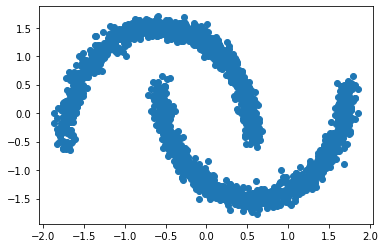

In [2]:
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
# normalize
X = StandardScaler().fit_transform(X)
plt.scatter(X[:, 0], X[:, 1])

## Base distribution $p_\mathrm{u}(\mathbf{u})$

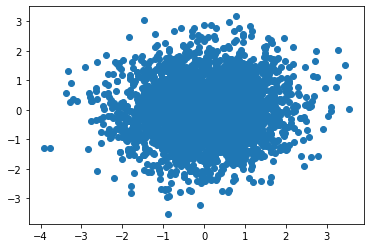

In [3]:
base_mu, base_cov = torch.zeros(2), torch.eye(2)
base_dist = MultivariateNormal(base_mu, base_cov)
Z = base_dist.rsample(sample_shape=(3000,)) # careful, named Z, not U
plt.scatter(Z[:, 0], Z[:, 1])
plt.show()

# Constructing Flows Part I: Finite Compositions

We can construct a flow with transformation $T$ by composing a finite number of simple transformations $T_k$ as follows:
$$T = T_K \circ \dots \circ T_1$$
Assuming $\mathbf{z}_0 = \mathbf{u}$ and $\mathbf{z}_K = \mathbf{x}$, the forward evaluation is:
$$\mathbf{z}_k = T_k(\mathbf{z}_{k-1}) \quad \text{for } k=1:K$$
and the inverse evaluation is:
$$\mathbf{z}_{k-1} = T_k^{-1}(\mathbf{z}_{k}) \quad \text{for } k=K:1$$
and the Jacoboian-determinant computation is:
$$\log|J_T(\mathbf{z})| = \log \left|\prod_{k=1}^K J_{T_k}(\mathbf{z}_{k-1})\right| = \sum_{k=1}^K \log |J_{T_k}(\mathbf{z}_{k-1})|$$
Increasing the number of composed sub-flows of $T$ pleasantly only results in $\mathcal{O}(K)$ growth in computational cost.

We can implement either $T_k$ or $T_k^{-1}$ using a neural network of parameters $\phi_k$, which we will denote as $f_{\phi_k}$. In either case, we must ensure that the network is invertible and has a tractable Jacobian determinant. However, in many implementations, even though the inverse of $f_{\phi_k}$ is guaranteed to exist, it can be expensive or even intractable to compute exactly.

By 'tractable Jacobian determinant', we mean a Jacobian determinant whose computation should be at most $\mathcal{O}(D)$ (compared to $\mathcal{O}(D^3)$ in the general case).

To simplify notation from here on, we will drop the dependence of the network parameters on $k$ and denote the neural network by $f_\phi$, its input by $\mathbf{z}$ and its output by $\mathbf{z}^\prime$ regardless of whether the network is taken to implement $T_k$ or $T_k^{-1}$.

## Autoregressive flows
Autoregressive flows transform any distribution $ p_x(\mathbf{x}) $ into a uniform distribution in $(0,1)^D$ using maps with a triangular Jacobian.
$f_\phi$ has the following form:
$$ \mathrm{z}_i^\prime = \tau(\mathrm{z}_i; \boldsymbol{h}_i) \quad \text{where} \quad \boldsymbol{h}_i = c_i( \mathbf{z}_{ < i}) $$
$ \tau $ is called the transformer and $ c_i $ the $i$-th conditioner.
The transformer must be a strictly monotonic function of $ \mathrm{z}_i $, but the conditioner does not need to be a bijection.
The parameters $ \phi $ of $ f_\phi $ are typically the parameters of the conditioner, but sometimes the transformer has its own parameters too (in addition to $ \boldsymbol{h}_i $).

Autoregressive flows are *universal approximators* provided the transformer and the conditioner are flexible enough to represent any function arbitrary well.

### Implementing the Transformer

#### Affine autoregressive flows

$$ \tau (\mrm{z}_i, \bs{h}_i ) = \alpha_i \mrm{z}_i + \beta_i $$ where $ \bs{h}_i = \{ \tilde{\alpha}_i, \beta_i \} $ and $ \alpha_i = \exp(\tilde{\alpha}_i) $.
- Simple and analytically tractable, but limited expressiveness
- Unknown whether they are universal approximators even with multiple layers

In [4]:
# Note: in the Python functions, inputs will typically be noted x and outputs z like classic neural networks
def affine_autoregressive_forward(x, h):
    alpha, beta = h
    z = alpha * x + beta
    return z

In [6]:
class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 

        if flip:
            x2, x1 = x1, x2
        
        # forward
        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2
        
        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
        
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [7]:
class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []
        
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

## Training/Viewing BoilerPlate Code

In [8]:
def train(model, epochs, batch_size, optim, scheduler):
    losses = []
    for _ in range(epochs):

        # get batch 
        X, _ = datasets.make_moons(n_samples=batch_size, noise=.05)
        X = torch.from_numpy(StandardScaler().fit_transform(X)).float()

        optim.zero_grad()
        z, log_pz, log_jacob = model(X)
        loss = (-log_pz - log_jacob).mean()
        losses.append(loss)

        loss.backward()
        optim.step()
        scheduler.step()
    return losses

In [9]:
def view(model, losses):
    plt.plot(losses)
    plt.title("Model Loss vs Epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    X_hat = model.inverse(Z).detach().numpy()
    plt.scatter(X_hat[:, 0], X_hat[:, 1])
    plt.title("Inverse of Normal Samples Z: X = F^-1(Z)")
    plt.show()

    n_samples = 3000
    X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
    X = torch.from_numpy(StandardScaler().fit_transform(X)).float()
    z, _, _ = model(X)
    z = z.detach().numpy()
    plt.scatter(z[:, 0], z[:, 1])
    plt.title("Transformation of Data Samples X: Z = F(X)")
    plt.show()

## Model Params

In [10]:
d = 2
k = 1

# Single Layer R_NVP

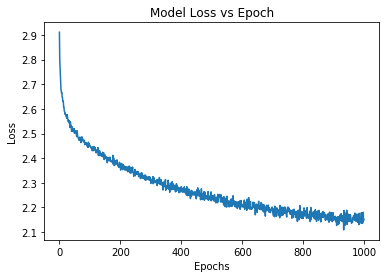

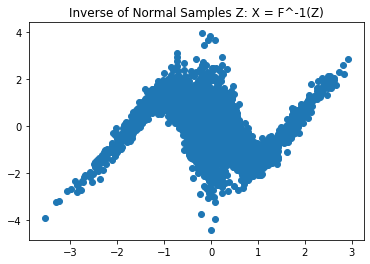

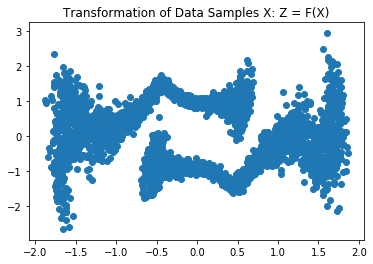

In [11]:
model = R_NVP(d, k, hidden=512)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)
n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)
view(model, losses)

# 3 Layer R_NVP

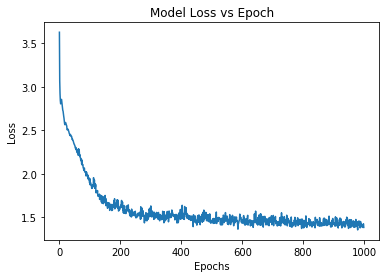

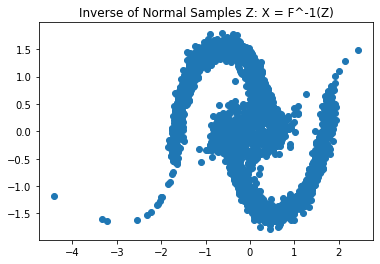

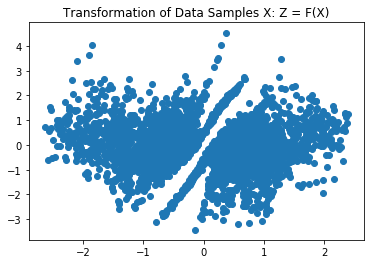

In [18]:
model = stacked_NVP(d, k, hidden=512, n=3)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)
view(model, losses)

# 5 Layer R_NVP

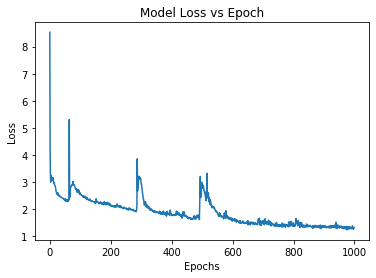

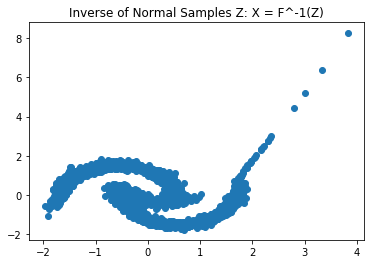

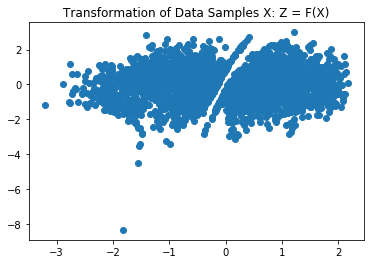

In [17]:
model = stacked_NVP(d, k, hidden=512, n=5)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)
view(model, losses)

# Sources and related stuff

## Repositories

- https://github.com/gebob19/introduction_to_normalizing_flows

- https://github.com/karpathy/pytorch-normalizing-flows

- https://github.com/fmu2/realNVP

- https://github.com/ikostrikov/pytorch-flows

- https://github.com/tonyduan/normalizing-flows

- https://github.com/chaiyujin/glow-pytorch

## Papers

- [Normalizing Flows for Probabilistic Modeling and Inference](https://arxiv.org/abs/1912.02762), Papamakarios et al., 2019